# Control Parameters 

In [45]:
%load_ext lab_black
%load_ext pycodestyle_magic
%flake8_on -i E203,E501 -m 119

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [46]:
import datetime
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import unittest
from pandas.util.testing import assert_frame_equal

In [47]:
class Msg_structure:
    def __init__(self, name=None, feature_list=None, feature_rename_list=None):
        self.name = name
        self.feature_list = feature_list
        self.feature_rename_list = feature_rename_list

## Modify This

In [48]:
data_sim_not_real = True
policy_xy_not_z = True
mix_sim_real_data = False

if policy_xy_not_z:
    SimResults_path = "./blimpSim/results_XY"
    RealResults_path = "./blimpReal/results_XY"
    MixResults_path = "./blimpSim/mix_results_XY"
else:
    SimResults_path = "./blimpSim/results_Z"
    RealResults_path = "./blimpReal/results_Z"
    MixResults_path = "./blimpSim/mix_results_Z"

if data_sim_not_real:
    data_folder_path = "./blimpSim/data/behaviour_policy"
    exp_index = [
        "coil",
        "double_coil",
        "reverse_coil",
        "reverse_double_coil",
        "down_coil",
        "reverse_down_coil",
        "square",
        "double_square",
        "lines",
        "lines2",
        "reverse_lines",
        "reverse_lines2",
        "manual",
        #             'manual_wind',
        #             'coil_reverse_double_wind',
        #             'coil_double_wind',
        #             'squre_double_wind'
    ]

else:
    data_folder_path = "./blimpReal/data/behaviour_policy"
    exp_index = [
        "rb1_201208_113634_6ca016cb2a35d1893682c089b7e118cfe3376122",
        "rb1_201214_123513_6ca016cb2a35d1893682c089b7e118cfe3376122",
        #         "rb2_201208_120334_747cb38938c76c535739e377d7ddcf7941929cb6",
        #         "rb2_201214_124645_1fb28b582a0c07b1e0c355c96faae3a309a6a028",
        #         "rb3_201208_125205_480c461174624e388ace9ac04608f91aba1ad15c",
        #         "rb3_201214_125422_23f66a6fd5be1805bf7cd07b0b1bf6655c6d6fe2",
        #         "rb4_201208_130611_927a9fcc88f638d5794133d62908a81779df33dd",
        #         "rb4_201214_134747_ba0a89de34290b12aeac7a1962bb37d0b15bb022",
        #         "rb5_201208_132010_c1b0c71b7bf8e4fd28cd75e5b7e3015a2d19ed23",
        #             'rb5_201214_160837_2d7233b5a264488155044c3ef7380fa44a54c7ef', # missing several msgs
        #             'rb6_201208_153458_50f011aee1008fd7935e8590229482234626fb28', # missing several msgs
        #         "rb8_201208_182852_e26f0b4801296bc4b9e1a98870333bf47e1925ef",
        #         "rb9_201208_164241_4bc6e0115172ea94797ea0ce08fcc639b781de0a",
        #         "rb10_201208_164242_f3252431ffc58f5fc6b41dcf531f159d9b5f6221",
        #         "rb11_201208_164241_b03cfd1b1cf180055bc0bc2e3d0eee0e73435cbe",
    ]


if data_sim_not_real:
    name_space = "blimp-"
    Imu_msg = Msg_structure(
        name=name_space + "tail-imu",
        feature_list=[
            "Time",
            "linear_acceleration.x",
            "linear_acceleration.y",
            "linear_acceleration.z",
        ],
        feature_rename_list=[
            "Time",
            "linear_acceleration.x",
            "linear_acceleration.y",
            "linear_acceleration.z",
        ],
    )

else:
    name_space = "machine_-"
    Imu_msg = Msg_structure(
        name=name_space + "Imu",
        feature_list=[
            "Time",
            "linear_acceleration.x",
            "linear_acceleration.y",
            "linear_acceleration.z",
        ],
        feature_rename_list=[
            "Time",
            "linear_acceleration.x",
            "linear_acceleration.y",
            "linear_acceleration.z",
        ],
    )
    transmitter_msg = Msg_structure(
        name=name_space + "Transmitter",
        feature_list=["Time", "ROSControlled", "Armed", "Thrust"],
        feature_rename_list=["Time", "ROSControlled", "Armed", "Thrust"],
    )

orientation_msg = Msg_structure(
    name=name_space + "pose",
    feature_list=[
        "Time",
        "orientation.x",
        "orientation.y",
        "orientation.z",
        "orientation.w",
        "angVelocity.x",
        "angVelocity.y",
        "angVelocity.z",
        "velocity.x",
        "velocity.y",
        "velocity.z",
    ],
    feature_rename_list=[
        "Time",
        "orientation.x",
        "orientation.y",
        "orientation.z",
        "orientation.w",
        "angVelocity.x",
        "angVelocity.y",
        "angVelocity.z",
        "velocity.linear.x",
        "velocity.linear.y",
        "velocity.linear.z",
    ],
)
autopilotInfo_msg = Msg_structure(
    name=name_space + "AutopilotInfo",
    feature_list=[
        "Time",
        "VelocityDesired.x",
        "VelocityDesired.y",
        "VelocityDesired.z",
    ],
    feature_rename_list=[
        "Time",
        "target.velocity.x",
        "target.velocity.y",
        "target.velocity.z",
    ],
)

if data_sim_not_real:
    obs_msg = [Imu_msg, orientation_msg, autopilotInfo_msg]
else:
    obs_msg = [
        orientation_msg,
        Imu_msg,
        autopilotInfo_msg,
        transmitter_msg,
    ]

actuator_command_msg = Msg_structure(
    name="actuatorcommand",
    feature_list=["Time", "data.data"],
    feature_rename_list=[
        "Time",
        "m2",
        "lfin",
        "rfin",
        "tfin",
        "bfin",
        "stick",
        "m1",
        "unused0",
        "m0",
        "unused1",
        "unused2",
        "unused3",
    ],
)
actuator_msg = Msg_structure(
    name=name_space + "actuators",
    feature_list=["Time", "data.data"],
    feature_rename_list=[
        "Time",
        "m2",
        "lfin",
        "rfin",
        "tfin",
        "bfin",
        "stick",
        "m1",
        "unused0",
        "m0",
        "unused1",
        "unused2",
        "unused3",
    ],
)
# act_msg = [actuator_msg, actuator_command_msg] #TODO: add act command as training data as well
act_msg = [actuator_msg]
all_msg = obs_msg + act_msg

## Try not to modify this

In [49]:
# Load data
bool_convert_rosbag2csv = True

num_transitions = 2
assert num_transitions >= 2, "num_transitions should be greater than 2"

obs_feature_msg = [msg.feature_rename_list for msg in obs_msg]
act_feature_msg = [msg.feature_rename_list for msg in act_msg]
obs_feature_list = list(set([item for sublist in obs_feature_msg for item in sublist]))
act_feature_list = list(set([item for sublist in act_feature_msg for item in sublist]))

time_feature_name = "Time"
purge_feature_list = [
    "ROSControlled",
    "Armed",
    "Thrust",
    "unused0",
    "unused1",
    "unused2",
    "unused3",
]
purge_feature_list.append(time_feature_name)

merge_feature = [time_feature_name]
merge_feature = merge_feature.append(act_feature_list)

# Data processing
round_time = 1 
assert round_time >= 1, "round_time should be greater than 1"

obs_filter_feature = [
    item
    for sublist in obs_feature_msg
    for item in sublist
    if item is not time_feature_name
]
act_filter_feature = ["m2", "lfin", "rfin", "tfin", "bfin", "stick", "m1", "m0"]
train_test_split_ratio = (0.99, 0.01)
act_scale_bnd = {
    "act_max": 2000,
    "act_min": 1000,
    "scaled_act_max": 1,
    "scaled_act_min": -1,
}

bool_addTarget = True
num_target_df = 7
target_distribution_const = 1
pseudo_target_min = np.array([-10, -10, -3])
pseudo_target_max = np.array([10, 10, 3])
target_feature_list = ["target.velocity.x", "target.velocity.y", "target.velocity.z"]
pseudo_target_dict = {
    "min": pseudo_target_min,
    "max": pseudo_target_max,
    "const": target_distribution_const,
    "feature_name": target_feature_list,
    "num": num_target_df,
}

bool_addNoise = True
num_noise_df = 7
noise_level = 0.05

# Reward Function
target_feature_list = target_feature_list
obsCost_feature_list = ["velocity.linear.x", "velocity.linear.y", "velocity.linear.z"]
xy_target_feature_list = target_feature_list[0:1]
xy_cost_feature_list = obsCost_feature_list[0:1]
z_target_feature_list = target_feature_list[2]
z_cost_feature_list = obsCost_feature_list[2]
actCost_feature_list = ["m0", "m1", "m2"]
actChangeCost_feature_list = ["m0", "m1", "m2", "stick", "tfin", "bfin", "lfin", "rfin"]

weight_next_obs = 1
weight_prev_obs = 0 * 1 / (num_transitions - 1)
weight_prev_act = 0 * 1 / (num_transitions - 1)
weight_prev_actChange = 0 * 1 / (num_transitions - 1)
reward_weights = (
    weight_next_obs,
    weight_prev_obs,
    weight_prev_act,
    weight_prev_actChange,
)

if policy_xy_not_z:
    weight_xy_obs, weigth_z_obs = 1, 0
else:
    weight_xy_obs, weigth_z_obs = 0, 1
obs_reward_weights = (weight_xy_obs, weigth_z_obs)

params = {
    "exp_index": exp_index,
    "data_folder_path": data_folder_path,
    "RealResults_path": RealResults_path,
    "SimResults_path": SimResults_path,
    "MixResults_path": MixResults_path,
    "bool_convert_rosbag2csv": bool_convert_rosbag2csv,
    "all_msg": all_msg,
    "obs_msg": obs_msg,
    "act_msg": act_msg,
    "num_transitions": num_transitions,
    "target_feature_list": target_feature_list,
    "xy_target_feature_list": xy_target_feature_list,
    "z_target_feature_list": z_target_feature_list,
    "obs_feature_list": obs_feature_list,
    "act_feature_list": act_feature_list,
    "time_feature_name": time_feature_name,
    "purge_feature_list": purge_feature_list,
    "round_time": round_time,
    "act_filter_feature": act_filter_feature,
    "obs_filter_feature": obs_filter_feature,
    "train_test_split_ratio": train_test_split_ratio,
    "act_scale_bnd": act_scale_bnd,
    "bool_addTarget": bool_addTarget,
    "pseudo_target_dict": pseudo_target_dict,
    "bool_addNoise": bool_addNoise,
    "num_noise_df": num_noise_df,
    "noise_level": noise_level,
    "obsCost_feature_list": obsCost_feature_list,
    "xy_cost_feature_list": xy_cost_feature_list,
    "z_cost_feature_list": z_cost_feature_list,
    "actCost_feature_list": actCost_feature_list,
    "actChangeCost_feature_list": actChangeCost_feature_list,
    "reward_weights": reward_weights,
    "obs_reward_weights": obs_reward_weights,
}

# Load Data

## Convert rosbag to csv

In [50]:
if params["bool_convert_rosbag2csv"]:
    import bagpy
    from bagpy import bagreader
    from pathlib import Path

    class ConvertBag2csv:
        def rosbag2csv(self, rosbag_path):
            b = bagreader(rosbag_path)
            csvfiles = []
            for t in b.topics:
                data = b.message_by_topic(t)
                csvfiles.append(data)

        def convert_rosbag2csv(self, directory):
            for root, dirs, files in os.walk(directory):
                for file in files:
                    if file.endswith(".bag"):
                        try:
                            bag_path = os.path.join(root, file)
                            file_path = os.path.splitext(bag_path)[0]
                            if not os.path.exists(file_path):
                                print(f"bag: start convert {file} ...")
                                self.rosbag2csv(bag_path)
                            else:
                                print(f"bag: {file} already converted")
                        except RuntimeError:
                            print(
                                f"bag: not able to convert {file}, maybe it is broken"
                            )

    print(f"data_folder_path: {data_folder_path}")
    clsConvertBag2csv = ConvertBag2csv()

    print("----------Start Converting Rosbag to CSV files----------")
    clsConvertBag2csv.convert_rosbag2csv(data_folder_path)
    print("----------Finish Convert----------")

data_folder_path: ./blimpSim/data/behaviour_policy
----------Start Converting Rosbag to CSV files----------
bag: square.bag already converted
bag: lines.bag already converted
bag: reverse_lines.bag already converted
bag: reverse_coil.bag already converted
bag: reverse_down_coil.bag already converted
bag: double_square.bag already converted
bag: coil.bag already converted
bag: lines2.bag already converted
bag: manual.bag already converted
bag: reverse_lines2.bag already converted
bag: double_coil.bag already converted
bag: reverse_double_coil.bag already converted
bag: down_coil.bag already converted
----------Finish Convert----------


## Define Transition

In [51]:
class objTransitions:
    def __init__(
        self,
        df=None,
        num_transitions=2,
        act_filter_feature=[],
        obs_filter_feature=[],
        purge_feature_list=["Time"],
        time_feature_name=["Time"],
        **kwargs
    ):
        self.df = df
        self.num_transitions = num_transitions
        assert self.num_transitions >= 2

        self.act_filter_feature = act_filter_feature
        self.obs_filter_feature = obs_filter_feature
        self.purge_feature_list = purge_feature_list
        self.time_feature_name = time_feature_name

        self.time = None
        self.act_trans_list = []
        self.obs_trans_list = []

        if df is not None:
            self._update()

    def _update(self):
        self.df_len = len(self.df.index)
        self.trans_len = len(self.df.index) - self.num_transitions
        self.time = self.get_time()
        self.act_trans_list, self.obs_trans_list = self._split_df(self.df)
        self._reset_index()

    def _calculate_delta_obs(self, obs, next_obs):
        return next_obs - obs

    def _split_df(self, df):
        act_trans_list, obs_trans_list = [], []
        for i in range(self.num_transitions):
            act_obs_trans = df[i : self.df_len - self.num_transitions + 1 + i]
            act_obs_trans.reset_index(drop=True)
            act_trans, obs_trans = (
                act_obs_trans[self.act_filter_feature],
                act_obs_trans[self.obs_filter_feature],
            )
            act_trans, obs_trans = self._purge_feature(act_trans), self._purge_feature(
                obs_trans
            )
            act_trans_list.append(act_trans)
            obs_trans_list.append(obs_trans)
        return act_trans_list, obs_trans_list

    def _purge_feature(self, df):
        for feature in self.purge_feature_list:
            if feature in df.columns:
                print("[ objTransition ] purge feature from df: ", feature)
                df = df.drop(feature, axis=1)
        return df

    def _reset_index(self):
        self.df.reset_index(drop=True, inplace=True)
        for i in range(self.num_transitions):
            self.act_trans_list[i].reset_index(drop=True, inplace=True)
            self.obs_trans_list[i].reset_index(drop=True, inplace=True)

    def get_next_transitions(self):
        next_act, next_obs = (
            self.act_trans_list[self.num_transitions - 1],
            self.obs_trans_list[self.num_transitions - 1],
        )
        return next_act, next_obs

    def get_cur_transitions(self):
        act, obs = (
            self.act_trans_list[self.num_transitions - 2],
            self.obs_trans_list[self.num_transitions - 2],
        )
        return act, obs

    def get_prev_transitions_list(self):
        prev_act_df_list, prev_obs_df_list = (
            self.act_trans_list[: self.num_transitions - 1],
            self.obs_trans_list[: self.num_transitions - 1],
        )
        return prev_act_df_list, prev_obs_df_list

    def get_delta_obs_transitions(self):
        _, next_obs = self.get_next_transitions()
        _, cur_obs = self.get_cur_transitions()
        delta_obs = self._calculate_delta_obs(cur_obs, next_obs)
        return delta_obs

    def get_time(self):
        return self.df[self.time_feature_name]

## Data Cleaner

In [52]:
class Data_cleaner:
    def clean_df(self, df, act_filter_feature, act_scale_bnd, round_time, **params):
        df = self.fill_df_NA(df)
        df = self.clean_act_bnd_error(df, act_scale_bnd, act_filter_feature)
        df = self.clean_time_sequence(df, round_time)
        return df

    def fill_df_NA(self, df):
        df = df.fillna(method="ffill")
        df = df.fillna(0)
        return df

    def clean_act_bnd_error(self, df, act_scale_bnd, act_filter_feature):
        df = self.clip_df(
            df, act_scale_bnd["act_min"], act_scale_bnd["act_max"], act_filter_feature
        )
        return df

    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[df[filter_feature] >= df_min]
            df = df[df[filter_feature] <= df_max]
        df.reset_index(drop=True, inplace=True)
        return df

    def clean_time_sequence(self, df, round_time=1):
        time = df["Time"]
        time = time.round(round_time)
        time = time.drop_duplicates()
        df = df.loc[time.index]
        return df

## Data Loader

In [53]:
class Data_loader:
    def load_csv_index(self, directory):
        csv_index = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    path = os.path.join(root, file)
                    csv_index.append(path)
        return csv_index

    # *******************************************

    def create_df_from_csvIndex(self, csv_index, **params):
        df_list = self.read_csvfiles(csv_index, **params)
        df = self.merge_df_list(df_list, merge_feature)
        df = df.sort_values(by="Time", ignore_index=True)
        return df

    def read_csvfiles(self, csv_index, **params):
        df_list = []
        for msg in all_msg:
            print("[ Load Data ] read_csvfiles: ", msg.name)

            if (msg.name == "actuatorcommand") and self.csv_not_exist(
                csv_index, msg.name
            ):
                print(
                    "[ Load Data ] read_csvfiles, actuatorcommand.csv does not exist, skip..."
                )

            else:
                df = self.create_df(
                    csv_index,
                    msg.name,
                    msg.feature_list,
                    msg.feature_rename_list,
                    **params
                )
                df_list.append(df)
        return df_list

    def create_df(
        self, csv_index, msg_name, feature_list, feature_rename_list, **params
    ):
        df = self.read_df_from_msg_in_csvIndex(csv_index, msg_name, **params)
        df = df[feature_list]
        df = self.unwrap_features(df)
        df.columns = feature_rename_list
        return df

    def read_df_from_msg_in_csvIndex(self, csv_index, msg_name, **params):
        for csv_name in csv_index:
            if msg_name in csv_name:
                print(csv_name)
                df = pd.read_csv(csv_name)
        return df

    def merge_df_list(self, df_list, merge_feature):
        df = df_list[0]
        iter_data = iter(df_list)
        next(iter_data)
        for item in iter_data:
            df = pd.merge(df, item, how="outer", on=merge_feature)
        return df

    # *******************************************

    def unwrap_features(self, df):
        for col_name in df.columns:
            col = df[col_name]
            col_data_type = self.check_col_data_type(col)

            if col_data_type == tuple:
                df = self.unwrap_tuple_feature(df, col_name)

        return df

    def check_col_data_type(self, col):
        first_element = col[0]
        data_type = type(first_element)

        if data_type == str:
            col = col.map(lambda x: eval(x))
            first_element = col[0]
            data_type = type(first_element)

        return data_type

    def unwrap_tuple_feature(self, df, col_name):
        tuple_col = df.pop(col_name)
        tuple_col = tuple_col.map(lambda x: eval(x))

        first_element = tuple_col[0]
        feature_len = len(first_element)

        feature_list = []
        for i in range(feature_len):
            new_feature = tuple_col.str[i]
            feature_list.append(new_feature)

        feature_pd = pd.concat(feature_list, axis=1)
        df = pd.concat([df, feature_pd], axis=1)

        return df

    # *******************************************

    def csv_not_exist(self, csv_index, msg_name):
        target_csv = [csv_name for csv_name in csv_index if msg_name in csv_name]
        if len(target_csv) == 0:
            return True
        else:
            return False

    def concat_df(self, df, df_new):
        if df is None:
            return df_new
        else:
            df = pd.concat([df, df_new], axis=0, ignore_index=True)
        return df

    # *******************************************

    def main(self, **params):
        df = None

        for exp in exp_index:
            exp_path = os.path.join(data_folder_path, exp)

            print("[ LOAD csv ]", exp)
            csv_index = self.load_csv_index(exp_path)

            print("[ CREATE df ] start", csv_index)
            new_df = self.create_df_from_csvIndex(csv_index, **params)

            print("[ Clean df ] start")
            clsDataCleaner = Data_cleaner()
            new_df = clsDataCleaner.clean_df(new_df, **params)

            print("[ CONCAT df ] start")
            df = self.concat_df(df, new_df)

        print("[ Create Transitions ] Start")
        objTrans = objTransitions(df, **params)

        print("[ LOAD csv ] Complete")
        return objTrans

In [54]:
clsLoadData = Data_loader()
objTrans = clsLoadData.main(**params)

[ LOAD csv ] coil
[ CREATE df ] start ['./blimpSim/data/behaviour_policy/coil/blimp-tail-position.csv', './blimpSim/data/behaviour_policy/coil/blimp-TransmitterInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-actuators.csv', './blimpSim/data/behaviour_policy/coil/blimp-GCSACTUATORS.csv', './blimpSim/data/behaviour_policy/coil/blimp-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-AutopilotInfo.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_speed.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-pose.csv', './blimpSim/data/behaviour_policy/coil/blimp-tail-transform.csv', './blimpSim/data/behaviour_policy/coil/blimp-ground_truth-position.csv']
[ Load Data ] read_csvfiles:  blimp-tail-imu
./blimpSim/data/behaviour_policy/coil/blimp-tail-imu.csv
[ Load Data ] read_c

In [55]:
objTrans.df

,Time,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,...,rfin,tfin,bfin,stick,m1,unused0,m0,unused1,unused2,unused3
0,40.720,0.584692,-0.003121,9.895689,-0.000153,0.023304,0.001966,0.999726,-0.023512,1.377563,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
1,40.750,0.594369,-0.002353,9.892905,-0.000150,0.023693,0.001969,0.999717,-0.013437,1.268200,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
2,40.855,0.614525,0.000782,9.879537,-0.000144,0.024206,0.001974,0.999705,-0.012377,1.201045,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
3,40.950,0.625241,-0.001828,9.871389,-0.000136,0.025340,0.001989,0.999677,-0.018434,0.884534,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
4,41.055,0.617526,-0.000545,9.875700,-0.000131,0.025696,0.001995,0.999668,-0.014570,0.687310,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105124,617.150,-0.304144,-0.126572,9.689609,0.028741,-0.013311,0.935699,0.351375,-1.287714,2.328632,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0
105125,617.255,-0.238274,-0.115861,9.703182,0.025906,-0.013492,0.935961,0.350891,-1.009839,2.496118,...,1485.0,1517.0,1517.0,1004.0,1732.0,1000.0,1732.0,1000.0,1000.0,1000.0
105126,617.350,-0.192966,-0.143941,9.700522,0.024722,-0.013468,0.936070,0.350687,-0.870729,2.556705,...,1485.0,1517.0,1517.0,1004.0,1732.0,1000.0,1732.0,1000.0,1000.0,1000.0
105127,617.455,-0.110049,-0.147673,9.716226,0.022329,-0.013338,0.936286,0.350275,-0.768718,2.630361,...,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,1500.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5b8d9fa0>,
      dtype=object)

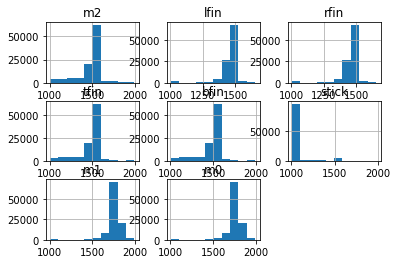

In [56]:
cur_act, cur_obs = objTrans.get_cur_transitions()
cur_act.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5bd104f0>,
      dtype=object)

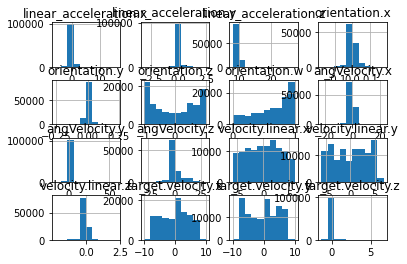

In [57]:
cur_obs.hist()

In [58]:
objTrans.get_time()

0          40.720
1          40.750
2          40.855
3          40.950
4          41.055
           ...   
105124    617.150
105125    617.255
105126    617.350
105127    617.455
105128    617.550
Name: Time, Length: 105129, dtype: float64

# Data processing

## Real Data Filter

In [59]:
class RealDataFilter:
    def __init__(self):
        pass

    def compute_flight_df(self, df):
        time, armed, thrust = df["Time"], df["Armed"], df["Thrust"]

        arm_start_time, arm_stop_time = self.get_arm_start_end_time(armed, time)
        flight_start_time, flight_stop_time = self.get_flight_time(
            time, thrust, arm_start_time, arm_stop_time
        )
        flight_df = self.get_flight_df(df, time, flight_start_time, flight_stop_time)

        return flight_df

    def get_arm_start_end_time(self, armed, time):
        armedValue = armed[armed.isna() != 1]
        tArmedValue = time[armed.isna() != 1]

        ta_np = tArmedValue.to_numpy()
        av_np = armedValue.to_numpy()

        gav_np = np.gradient(av_np)
        idxStart = np.where(gav_np > 0)
        idxStop = np.where(gav_np < 0)

        tArmedStart = ta_np[idxStart]
        tArmedStop = ta_np[idxStop]

        tArmedStart = tArmedStart[range(0, len(tArmedStart), 2)]
        tArmedStop = tArmedStop[range(0, len(tArmedStop), 2)]

        if tArmedStart.shape[0] > tArmedStop.shape[0]:
            tArmedStop = np.append(tArmedStop, ta_np[-1])

        return tArmedStart, tArmedStop

    def get_flight_time(
        self,
        time,
        thrust,
        tArmedStart,
        tArmedStop,
        thrustThreshold=0.15,
        tDeltaThrust=10,
        tDeltaDisarm=15,
    ):
        """
        - thrust_thresh: Thrust threshold. Flight is considered to be started when vehicel is
                    armed and for the first time the thrust is higher than threshold value
        - time_deltaThrust_thresh: Time delta added to time point where vehicle is armed and
                    thrust value crosses threshold. During take off vehicle usually is pushed
                    around by helpers, that is why this time delta is necessary to exclude the
                    take off phase from the data
        - time_deltaDisarm: Since vehicle is disarmed in advance of a crash or a landing or at
                    least shortly after, tDeltaDisarm  is subtracted from the time point when
                    disarming takes place. That way it is made sure that only flight data is considered
        """

        tFlightStart, tFlightStop = [], []
        for i in range(len(tArmedStart)):
            tArmedStartTemp = tArmedStart[i]
            tArmedStopTemp = tArmedStop[i]

            thrustTemp = thrust[(time > tArmedStartTemp) & (time < tArmedStopTemp)]
            tThrustTemp = time[(time > tArmedStartTemp) & (time < tArmedStopTemp)]

            if thrustTemp[thrustTemp > thrustThreshold].empty:
                continue

            idxThrustThreshold = thrustTemp[thrustTemp > thrustThreshold].index[0]
            tFlightStartTemp = tThrustTemp[idxThrustThreshold] + tDeltaThrust
            tFlightStopTemp = tArmedStopTemp - tDeltaDisarm

            tFlightStart.append(tFlightStartTemp)
            tFlightStop.append(tFlightStopTemp)

        return tFlightStart, tFlightStop

    def get_flight_df(self, df, time, tFlightStart, tFlightStop):
        dfFlightList = []
        dfFlight = []
        for i in range(len(tFlightStart)):
            dfTemp = df[(time > tFlightStart[i]) & (time < tFlightStop[i])]
            dfFlightList.append(dfTemp)
            dfFlight = pd.concat(dfFlightList, ignore_index=True)
        return dfFlight

    def main(self, objTrans, **params):
        df = self.compute_flight_df(objTrans.df)
        objTrans = objTransitions(df, **params)
        return objTrans

In [60]:
if not data_sim_not_real:
    print(' Filter Flight Time data')
    clsRealDataFilter = RealDataFilter()
    objTrans = clsRealDataFilter.main(objTrans)

## Data Processor

In [61]:
class Data_processor:
    def data_processsing(self, df, **params):
        df = self.scale_df_act(df, act_scale_bnd, act_filter_feature)
        if bool_addTarget:
            df = self.duplicate_target_df(df, pseudo_target_dict)
        if bool_addNoise:
            df = self.duplicate_Noise_df(df, num_noise_df, noise_level)
        df = self.clip_scaled_df(df, act_scale_bnd, act_filter_feature)
        return df

    def scale_df_act(self, df, act_scale_bnd, act_filter_feature):
        act_max, act_min = act_scale_bnd["act_max"], act_scale_bnd["act_min"]
        scaled_act_max, scaled_act_min = (
            act_scale_bnd["scaled_act_max"],
            act_scale_bnd["scaled_act_min"],
        )

        act = df[act_filter_feature]
        act = self.minmax_scale_df(
            act, act_max, act_min, scaled_act_max, scaled_act_min
        )
        df[act_filter_feature] = act
        return df

    def minmax_scale_df(self, df, df_max, df_min, target_max, target_min):
        df_mean = (df_max + df_min) / 2
        target_mean = (target_max + target_min) / 2

        scale = (df_max - df_min) / (target_max - target_min)
        df = (df - df_mean) / scale + target_mean
        return df

    def duplicate_target_df(self, df, pseudo_target_dict, seed=None):
        if seed is not None:
            np.random.seed(seed)
        target_min = pseudo_target_dict["min"]
        target_max = pseudo_target_dict["max"]
        target_scale_const = pseudo_target_dict["const"]
        target_feature_list = pseudo_target_dict["feature_name"]
        num_target = pseudo_target_dict["num"]

        new_df = df
        df_len = len(df.index)
        pseudo_target_shape = (df_len, len(target_feature_list))

        for i in range(num_target):
            pseudo_target_df = self.generate_pseudo_target(
                pseudo_target_shape, target_scale_const, target_min, target_max
            )
            pseudo_target_df.columns = target_feature_list
            df[target_feature_list] = pseudo_target_df
            new_df = pd.concat([new_df, df], axis=0, ignore_index=True)
        return new_df

    def generate_pseudo_target(
        self, pseudo_target_shape, target_scale_const, target_min, target_max
    ):
        target_noise = target_scale_const * np.random.uniform(
            pseudo_target_min, pseudo_target_max, pseudo_target_shape
        )
        pseudo_target_df = pd.DataFrame(target_noise)
        return pseudo_target_df

    def duplicate_Noise_df(self, df, num_noise_df, noise_level, seed=None):
        if seed is not None:
            np.random.seed(seed)
        new_df = df
        time_df = df["Time"]
        df = df.drop("Time", axis=1)
        for i in range(num_noise_df):
            noised_df = self.addNoise_df(df, noise_level)
            noised_df = pd.concat([time_df, noised_df], axis=1)
            new_df = pd.concat([new_df, noised_df], axis=0, ignore_index=True)

        return new_df

    def addNoise_df(self, df, noise_level):
        df_range = df.max() - df.min()
        df_noise_range = noise_level * df_range / 2
        noise = np.random.uniform(-df_noise_range, df_noise_range, df.shape)
        df = df + noise
        return df

    def clip_scaled_df(self, df, act_scale_bnd, act_filter_feature):
        scaled_act_min, scaled_act_max = (
            act_scale_bnd["scaled_act_min"],
            act_scale_bnd["scaled_act_max"],
        )
        new_df = self.clip_df(df, scaled_act_min, scaled_act_max, act_filter_feature)
        return new_df

    def clip_df(self, df, df_min, df_max, df_filter_feature):
        for filter_feature in df_filter_feature:
            df = df[df[filter_feature] >= df_min]
            df = df[df[filter_feature] <= df_max]
        df.reset_index(drop=True, inplace=True)
        return df

    # *******************************************

    def split_trainTest_df(self, df, train_test_split_ratio, **params):
        df_len = len(df.index)
        idx = self.get_trainTest_index(df_len, train_test_split_ratio)
        df_train, df_test = self.split_df(df, idx)
        return df_train, df_test

    def split_df(self, df, idx):
        idx_train, idx_test = idx
        df_train, df_test = df.loc[idx_train], df.loc[idx_test]
        df_train = df_train.reset_index(drop=True)
        df_test = df_test.reset_index(drop=True)
        return df_train, df_test

    def get_trainTest_index(self, n_data, ratio):
        ratio_train, ratio_test = ratio
        n_train = int(n_data * ratio_train)

        idx_randperm = np.random.permutation(n_data - 1)
        idx_train = np.sort(idx_randperm[:n_train])
        idx_test = np.sort(idx_randperm[n_train + 1 :])
        return (idx_train, idx_test)

    # *******************************************

    def main(self, objTrans, **params):
        df = objTrans.df

        print(
            "[ Data processing ] Scale action data, Add noise, Round data, clip data "
        )
        df = self.data_processsing(df, **params)

        print("[ Data processing ] Split train and test data ")
        df_train, df_test = self.split_trainTest_df(df, **params)

        print("[ Data processing ] Complete")
        objTrans_train, objTrans_test = (
            objTransitions(df_train, **params),
            objTransitions(df_test, **params),
        )

        return objTrans_train, objTrans_test

In [62]:
clsDataProcessor = Data_processor()
objTrans_train, objTrans_test = clsDataProcessor.main(objTrans, **params)

[ Data processing ] Scale action data, Add noise, Round data, clip data 
[ Data processing ] Split train and test data 
[ Data processing ] Complete


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5bd68610>,
      dtype=object)

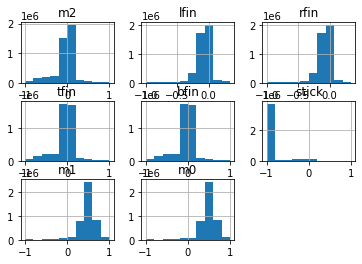

In [63]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_act.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5b800460>,
      dtype=object)

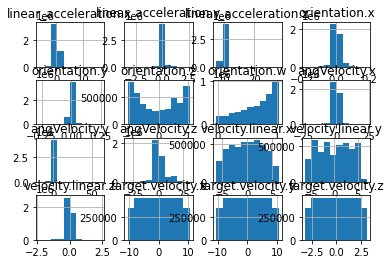

In [64]:
cur_act, cur_obs = objTrans_train.get_cur_transitions()
cur_obs.hist()

## Unit Test

In [65]:
class TestDataProcessor(unittest.TestCase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.clsDataProcessor = Data_processor()
        self.act_scale_bnd = {
            "act_max": 2000,
            "act_min": 1000,
            "scaled_act_max": 1,
            "scaled_act_min": -1,
        }

    def test_scale_df_act(self):
        test_df = pd.DataFrame(
            {"m0": [1000, 1500, 2000], "m1": [100, 200, 300], "m2": [3000, 5000, 10000]}
        )
        act_filter_feature = ["m0", "m1", "m2"]

        example = pd.DataFrame(
            {"m0": [-1.0, 0.0, 1.0], "m1": [-2.8, -2.6, -2.4], "m2": [3.0, 7.0, 17.0]}
        )

        results = self.clsDataProcessor.scale_df_act(
            test_df, self.act_scale_bnd, act_filter_feature
        )
        assert_frame_equal(results, example)

    def test_duplicate_target_df(self):
        test_df = pd.DataFrame({"df": [0.1], "t0": [3], "t1": [2], "t2": [1]})
        target_min = np.array([-10, -10, -3])
        target_max = np.array([10, 10, 3])
        target_scale_const = 1
        target_feature_list = ["t0", "t1", "t2"]
        num_target = 2
        target_dict = {
            "min": target_min,
            "max": target_max,
            "const": target_scale_const,
            "feature_name": target_feature_list,
            "num": num_target,
        }

        example = pd.DataFrame(
            {
                "df": [0.1, 0.1, 0.1],
                "t0": [3.929384, 3.929384, 1.026295],
                "t1": [-4.277213, -4.277213, 4.389379],
                "t2": [-1.638891, -1.638891, -0.461361],
            }
        )

        results = self.clsDataProcessor.duplicate_target_df(
            test_df, target_dict, seed=123
        )
        assert_frame_equal(results, example)

    def test_duplicate_Noise_df(self):
        test_df = pd.DataFrame(
            {"Time": [0, 1], "f1": [0, 0], "f2": [1000, 2000], "f3": [-1000, -999]}
        )
        num_noise_df = 2
        noise_level = 0.5

        example = pd.DataFrame(
            {
                "Time": [0, 1, 0, 1, 0, 1],
                "f1": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                "f2": [1000, 2000, 893.069667, 2109.734485, 1092.414869, 1921.589008],
                "f3": [
                    -1000,
                    -999,
                    -1000.136574,
                    -999.038447,
                    -1000.009534,
                    -998.885475,
                ],
            }
        )

        results = self.clsDataProcessor.duplicate_Noise_df(
            test_df, num_noise_df, noise_level, seed=123
        )
        assert_frame_equal(results, example)

    def test_clip_scaled_df(self):
        test_df = pd.DataFrame(
            {"m0": [-1.0, 0.0, 1.0], "m1": [0.0, -2.6, -2.4], "m2": [1.0, 7.0, 17.0]}
        )
        act_filter_feature = ["m0", "m1", "m2"]

        example = pd.DataFrame({"m0": [-1.0], "m1": [0.0], "m2": [1.0]})

        results = self.clsDataProcessor.clip_scaled_df(
            test_df, self.act_scale_bnd, act_filter_feature
        )
        assert_frame_equal(results, example)


unittest.main(argv=[""], verbosity=2, exit=False)

test_clip_scaled_df (__main__.TestDataProcessor) ... ok
test_duplicate_Noise_df (__main__.TestDataProcessor) ... ok
test_duplicate_target_df (__main__.TestDataProcessor) ... ok
test_scale_df_act (__main__.TestDataProcessor) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


# Design Reward Function

## Reward Function

In [66]:
class RewardFn:
    def reward_fn(
        self,
        next_obs_df,
        prev_act_list,
        prev_obs_list,
        obs_reward_weights=(1, 1),
        reward_weights=(1, 0, 1, 1),
        **params
    ):

        next_obsCost_np = 0
        next_obsCost_np = self.calculate_obsCost(
            next_obs_df, obs_reward_weights, **params
        )

        prev_obsCost_np = 0
        for obs_df in prev_obs_list:
            obsCost_np = self.calculate_obsCost(obs_df, obs_reward_weights, **params)
            prev_obsCost_np += obsCost_np

        prev_actCost_np = 0
        for act_df in prev_act_list:
            actCost_np = self.calculate_actCost(act_df, actCost_feature_list)
            prev_actCost_np += actCost_np

        prev_actChangeCost_np = 0
        for i in range(len(prev_act_list) - 1):
            act_df, next_act_df = prev_act_list[i], prev_act_list[i + 1]
            actChangeCost_np = self.calculate_actChangeCost(
                act_df, next_act_df, actChangeCost_feature_list
            )
            prev_actChangeCost_np += actChangeCost_np

        rewards = (
            reward_weights[0] * next_obsCost_np
            + reward_weights[1] * prev_obsCost_np
            + reward_weights[2] * prev_actCost_np
            + reward_weights[3] * prev_actChangeCost_np
        )

        rewards = pd.DataFrame({"rewards": rewards})
        info = pd.DataFrame(
            {
                "next_obsCost": next_obsCost_np,
                "prev_obsCost": prev_obsCost_np,
                "prev_actCost": prev_actCost_np,
                "prev_actChangeCost": prev_actChangeCost_np,
            }
        )
        return rewards, info

    def calculate_obsCost(self, obs_df, obs_reward_weights, **params):
        xy_target_df = obs_df[xy_target_feature_list]
        xy_cost_df = obs_df[xy_cost_feature_list]
        z_target_df = obs_df[z_target_feature_list]
        z_cost_df = obs_df[z_cost_feature_list]
        xyCost_np = obs_reward_weights[0] * self.calculate_xyCost(
            xy_cost_df, xy_target_df
        )
        zCost_np = obs_reward_weights[1] * self.calculate_zCost(z_cost_df, z_target_df)
        obs_cost_np = xyCost_np + zCost_np
        return obs_cost_np

    def calculate_xyCost(self, xy_df, xy_target_df):
        xyCost_np = xy_target_df.to_numpy() - xy_df.to_numpy()
        xyCost_np = -np.linalg.norm(xyCost_np, axis=1)
        return xyCost_np

    def calculate_zCost(self, z_df, z_target_df):
        zCost_np = z_target_df.to_numpy() - z_df.to_numpy()
        zCost_np = -np.abs(zCost_np).reshape(
            zCost_np.shape[0],
        )
        return zCost_np

    def calculate_actCost(self, act_df, actCost_feature_list):
        actCost_np = act_df[actCost_feature_list].to_numpy()
        actCost_np = -np.linalg.norm(actCost_np, axis=1)
        return actCost_np

    def calculate_actChangeCost(self, act_df, next_act_df, actChangeCost_feature_list):
        actChangeCost_np = (
            next_act_df[actChangeCost_feature_list].to_numpy()
            - act_df[actChangeCost_feature_list].to_numpy()
        )
        actChangeCost_np = -np.linalg.norm(actChangeCost_np, axis=1)
        return actChangeCost_np

## Split input and output data

In [67]:
class Splitter:
    def split_xy(self, prev_act_list, prev_obs_list, next_obs, rewards):
        x_df_list = []
        for obs_df, act_df in zip(prev_obs_list, prev_act_list):
            obs_act_df = pd.concat([obs_df, act_df], axis=1)
            x_df_list.append(obs_act_df)
        x = pd.concat(x_df_list, axis=1)
        y = pd.concat([rewards, next_obs], axis=1)
        return x, y

    def main(self, objTrans, **params):
        prev_act_list, prev_obs_list = objTrans.get_prev_transitions_list()
        next_act, next_obs = objTrans.get_next_transitions()

        clsRewardFn = RewardFn()
        rewards, info = clsRewardFn.reward_fn(
            next_obs, prev_act_list, prev_obs_list, **params
        )
        x, y = self.split_xy(prev_act_list, prev_obs_list, next_obs, rewards)

        return x, y, rewards, info

In [68]:
clsSplitter = Splitter()
x_train, y_train, rewards_train, info_train = clsSplitter.main(objTrans_train, **params)
x_test, y_test, rewards_test, info_test = clsSplitter.main(objTrans_test, **params)

In [78]:
x_train

,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
4348218,0.007625,-0.021064,0.000063,0.054195,0.002229,-0.944403,0.429794,0.426171
4348219,-0.010344,-0.030870,-0.011627,0.048274,-0.007783,-0.948644,0.431918,0.429161
4348220,0.033573,-0.053277,-0.041113,-0.013246,0.025678,-0.957107,0.472186,0.489011
4348221,0.048963,-0.044311,-0.014485,0.006400,0.038348,-0.952625,0.467159,0.487500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5bd94280>,
      dtype=object)

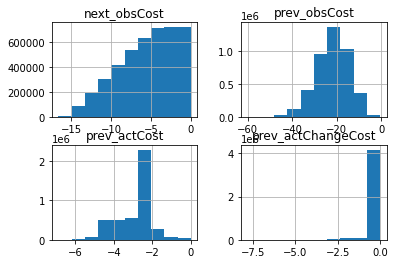

In [70]:
info_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab5bd94d90>]],
      dtype=object)

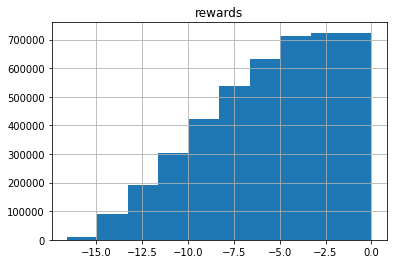

In [71]:
rewards_train.hist()

# Save data

## Save Data to CSV

In [28]:
if data_sim_not_real:
    print(f" Save to Simulation Results Path: {SimResults_path}")
    cur_act, cur_obs = objTrans_train.get_cur_transitions()
    cur_obs.to_csv(os.path.join(SimResults_path, "obs"), index=False)
    cur_act.to_csv(os.path.join(SimResults_path, "act"), index=False)
    x_train.to_csv(os.path.join(SimResults_path, "x_train"), index=False)
    y_train.to_csv(os.path.join(SimResults_path, "y_train"), index=False)
    x_test.to_csv(os.path.join(SimResults_path, "x_test"), index=False)
    y_test.to_csv(os.path.join(SimResults_path, "y_test"), index=False)

    act_read_test = pd.read_csv(os.path.join(SimResults_path, "act"))
    obs_read_test = pd.read_csv(os.path.join(SimResults_path, "obs"))
    x_train_read_test = pd.read_csv(os.path.join(SimResults_path, "x_train"))
    y_train_read_test = pd.read_csv(os.path.join(SimResults_path, "y_train"))

else:
    print(f" Save to Real Results Path: {RealResults_path}")
    cur_act, cur_obs = objTrans_train.get_cur_transitions()
    cur_obs.to_csv(os.path.join(RealResults_path, "obs"), index=False)
    cur_act.to_csv(os.path.join(RealResults_path, "act"), index=False)
    x_train.to_csv(os.path.join(RealResults_path, "x_train"), index=False)
    y_train.to_csv(os.path.join(RealResults_path, "y_train"), index=False)
    x_test.to_csv(os.path.join(RealResults_path, "x_test"), index=False)
    y_test.to_csv(os.path.join(RealResults_path, "y_test"), index=False)

    act_read_test = pd.read_csv(os.path.join(RealResults_path, "act"))
    obs_read_test = pd.read_csv(os.path.join(RealResults_path, "obs"))
    x_train_read_test = pd.read_csv(os.path.join(RealResults_path, "x_train"))
    y_train_read_test = pd.read_csv(os.path.join(RealResults_path, "y_train"))

 Save to Real Results Path: ./blimpReal/results_XY


In [29]:
act_read_test

,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.346000,0.000000,0.000000,0.346000,0.346000,-0.040000,0.224000,0.224000
1,0.372000,0.000000,0.000000,0.372000,0.372000,-0.036000,0.232000,0.232000
2,0.442000,0.000000,0.000000,0.442000,0.442000,-0.036000,0.246000,0.246000
3,0.500000,0.000000,0.000000,0.500000,0.500000,-0.040000,0.260000,0.260000
4,0.530000,0.000000,0.000000,0.530000,0.530000,-0.036000,0.256000,0.256000
...,...,...,...,...,...,...,...,...
45045,0.026385,-0.005299,-0.036498,0.023639,-0.011429,-0.325019,0.290975,0.283435
45046,-0.009821,0.035185,0.008179,0.028754,0.027006,-0.288741,0.288246,0.281874
45047,-0.030267,0.028199,-0.017745,0.028764,0.003126,-0.332089,0.286882,0.291407
45048,0.035077,0.003963,0.038791,0.017184,-0.004780,-0.291280,0.267984,0.275092


In [30]:
obs_read_test

,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,0.022583,0.059098,0.175441,0.982455,6.416730,-2.495774,-1.012899,0.861034,0.017769,-0.086961,1.067425,-0.904998,-9.525103,2.150096,1.544479,2.941391
1,0.024767,0.057734,0.170457,0.983360,2.591935,-3.543970,-13.902404,0.853818,0.008835,-0.066604,0.883501,-0.648477,-9.461720,-9.962844,1.359368,0.578538
2,0.028555,0.056422,0.165418,0.984194,2.052119,-2.743255,-11.181817,0.874612,-0.054235,-0.047649,1.095721,-1.099764,-9.494010,8.258221,3.353839,-0.762745
3,0.029745,0.055752,0.161460,0.984854,4.683132,-0.735427,6.289881,0.897282,-0.091351,-0.025907,0.632375,-0.628288,-9.394749,-5.312100,-6.188883,-2.737934
4,0.031738,0.054446,0.155271,0.985860,2.447562,-0.271320,0.306804,0.897198,-0.146089,-0.010188,0.663815,-0.880058,-9.365648,0.221957,2.499063,-0.742932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45045,-0.012426,0.108081,0.898474,0.549697,0.354415,3.303615,23.046331,-0.348652,-0.329624,0.005897,1.143324,-0.647559,-9.473430,4.494823,-6.106799,-0.737048
45046,-0.011222,0.114091,0.857551,0.459647,-1.250294,1.406024,18.629448,-0.232135,-0.341471,0.087593,1.096261,-0.559547,-9.587782,-0.924880,9.066665,-1.556176
45047,-0.011252,0.104981,0.890305,0.514260,-2.944244,3.141764,21.108381,-0.378071,-0.405390,0.130817,1.013595,-0.700299,-9.371636,-1.631172,-2.027469,2.508968
45048,-0.015641,0.107003,0.916995,0.421061,-4.203381,2.111101,21.330753,-0.188378,-0.243108,0.124939,1.198833,-0.631520,-9.297824,8.707922,-3.233645,-1.215047


In [31]:
x_train_read_test

,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,...,target.velocity.y,target.velocity.z,m2,lfin,rfin,tfin,bfin,stick,m1,m0
0,0.022583,0.059098,0.175441,0.982455,6.416730,-2.495774,-1.012899,0.861034,0.017769,-0.086961,...,1.544479,2.941391,0.346000,0.000000,0.000000,0.346000,0.346000,-0.040000,0.224000,0.224000
1,0.024767,0.057734,0.170457,0.983360,2.591935,-3.543970,-13.902404,0.853818,0.008835,-0.066604,...,1.359368,0.578538,0.372000,0.000000,0.000000,0.372000,0.372000,-0.036000,0.232000,0.232000
2,0.028555,0.056422,0.165418,0.984194,2.052119,-2.743255,-11.181817,0.874612,-0.054235,-0.047649,...,3.353839,-0.762745,0.442000,0.000000,0.000000,0.442000,0.442000,-0.036000,0.246000,0.246000
3,0.029745,0.055752,0.161460,0.984854,4.683132,-0.735427,6.289881,0.897282,-0.091351,-0.025907,...,-6.188883,-2.737934,0.500000,0.000000,0.000000,0.500000,0.500000,-0.040000,0.260000,0.260000
4,0.031738,0.054446,0.155271,0.985860,2.447562,-0.271320,0.306804,0.897198,-0.146089,-0.010188,...,2.499063,-0.742932,0.530000,0.000000,0.000000,0.530000,0.530000,-0.036000,0.256000,0.256000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45045,-0.012426,0.108081,0.898474,0.549697,0.354415,3.303615,23.046331,-0.348652,-0.329624,0.005897,...,-6.106799,-0.737048,0.026385,-0.005299,-0.036498,0.023639,-0.011429,-0.325019,0.290975,0.283435
45046,-0.011222,0.114091,0.857551,0.459647,-1.250294,1.406024,18.629448,-0.232135,-0.341471,0.087593,...,9.066665,-1.556176,-0.009821,0.035185,0.008179,0.028754,0.027006,-0.288741,0.288246,0.281874
45047,-0.011252,0.104981,0.890305,0.514260,-2.944244,3.141764,21.108381,-0.378071,-0.405390,0.130817,...,-2.027469,2.508968,-0.030267,0.028199,-0.017745,0.028764,0.003126,-0.332089,0.286882,0.291407
45048,-0.015641,0.107003,0.916995,0.421061,-4.203381,2.111101,21.330753,-0.188378,-0.243108,0.124939,...,-3.233645,-1.215047,0.035077,0.003963,0.038791,0.017184,-0.004780,-0.291280,0.267984,0.275092


In [32]:
y_train_read_test

,rewards,orientation.x,orientation.y,orientation.z,orientation.w,angVelocity.x,angVelocity.y,angVelocity.z,velocity.linear.x,velocity.linear.y,velocity.linear.z,linear_acceleration.x,linear_acceleration.y,linear_acceleration.z,target.velocity.x,target.velocity.y,target.velocity.z
0,-10.816662,0.024767,0.057734,0.170457,0.983360,2.591935,-3.543970,-13.902404,0.853818,0.008835,-0.066604,0.883501,-0.648477,-9.461720,-9.962844,1.359368,0.578538
1,-7.383609,0.028555,0.056422,0.165418,0.984194,2.052119,-2.743255,-11.181817,0.874612,-0.054235,-0.047649,1.095721,-1.099764,-9.494010,8.258221,3.353839,-0.762745
2,-6.209382,0.029745,0.055752,0.161460,0.984854,4.683132,-0.735427,6.289881,0.897282,-0.091351,-0.025907,0.632375,-0.628288,-9.394749,-5.312100,-6.188883,-2.737934
3,-0.675241,0.031738,0.054446,0.155271,0.985860,2.447562,-0.271320,0.306804,0.897198,-0.146089,-0.010188,0.663815,-0.880058,-9.365648,0.221957,2.499063,-0.742932
4,-5.526374,0.031344,0.054227,0.151469,0.986476,1.117321,-0.099008,-3.358958,0.906896,-0.156349,0.012432,0.842237,-1.355096,-9.544238,-4.619479,-7.406524,1.610401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45045,-0.692745,-0.011222,0.114091,0.857551,0.459647,-1.250294,1.406024,18.629448,-0.232135,-0.341471,0.087593,1.096261,-0.559547,-9.587782,-0.924880,9.066665,-1.556176
45046,-1.253100,-0.011252,0.104981,0.890305,0.514260,-2.944244,3.141764,21.108381,-0.378071,-0.405390,0.130817,1.013595,-0.700299,-9.371636,-1.631172,-2.027469,2.508968
45047,-8.896299,-0.015641,0.107003,0.916995,0.421061,-4.203381,2.111101,21.330753,-0.188378,-0.243108,0.124939,1.198833,-0.631520,-9.297824,8.707922,-3.233645,-1.215047
45048,-9.961756,-0.010581,0.109540,0.864339,0.440805,-2.493299,2.585787,19.514507,-0.402644,-0.447163,0.206337,1.066001,-0.465798,-9.405981,9.559112,4.085235,0.578382


## Mix Real and Simulation data

In [33]:
if mix_sim_real_data:
    act_real = pd.read_csv(os.path.join(RealResults_path, "act"))
    obs_real = pd.read_csv(os.path.join(RealResults_path, "obs"))
    x_train_real = pd.read_csv(os.path.join(RealResults_path, "x_train"))
    y_train_real = pd.read_csv(os.path.join(RealResults_path, "y_train"))
    x_test_real = pd.read_csv(os.path.join(RealResults_path, "x_test"))
    y_test_real = pd.read_csv(os.path.join(RealResults_path, "y_test"))

    act_sim = pd.read_csv(os.path.join(SimResults_path, "act"))
    obs_sim = pd.read_csv(os.path.join(SimResults_path, "obs"))
    x_train_sim = pd.read_csv(os.path.join(SimResults_path, "x_train"))
    y_train_sim = pd.read_csv(os.path.join(SimResults_path, "y_train"))
    x_test_sim = pd.read_csv(os.path.join(SimResults_path, "x_test"))
    y_test_sim = pd.read_csv(os.path.join(SimResults_path, "y_test"))

    act_mix = pd.concat([act_sim, act_real], axis=0)
    obs_mix = pd.concat([obs_sim, obs_real], axis=0)
    x_train_mix = pd.concat([x_train_sim, x_train_real], axis=0)
    y_train_mix = pd.concat([y_train_sim, y_train_real], axis=0)
    x_test_mix = pd.concat([x_test_sim, x_test_real], axis=0)
    y_test_mix = pd.concat([y_test_sim, y_test_real], axis=0)

    obs_mix.to_csv(os.path.join(MixResults_path, "obs"), index=False)
    act_mix.to_csv(os.path.join(MixResults_path, "act"), index=False)
    x_train_mix.to_csv(os.path.join(MixResults_path, "x_train"), index=False)
    y_train_mix.to_csv(os.path.join(MixResults_path, "y_train"), index=False)
    x_test_mix.to_csv(os.path.join(MixResults_path, "x_test"), index=False)
    y_test_mix.to_csv(os.path.join(MixResults_path, "y_test"), index=False)